In [1]:
%matplotlib inline
import pandas as pd
from mpl_toolkits.basemap import Basemap
import numpy as np
from utilities import timestamps
from utilities.plotting import equi
from utilities.polygon_selection import get_node_data
from utilities.stats import calc_fmd_stats_with_mc
import matplotlib.pyplot as plt
from scipy import spatial

In [2]:
df = pd.read_csv('data/ccu.dat', delimiter='\t', names=['lon', 'lat', 'decimal_year', 'month', 'day', 'mag'
                                                        , 'depth', 'hour', 'minute', 'second', 'horizontal_error'
                                                        , 'depth_error', 'mag_err'])

In [3]:
df['timestamp'] = df.decimal_year.apply(timestamps.convert_decimal_year_to_numpy_datetime64)

In [4]:
foreshock_time = '2016-04-14 12:26:00'
mainshock_time = '2016-04-15 16:24:28'

start_date = '2000-01-01 00:00:00'
df = df[df.timestamp >= start_date]

# df = df[df.timestamp >= '2000-01-01 00:00:00']
# df = df[df.timestamp >= '2001-10-01 00:00:00']
df = df[df.timestamp < foreshock_time]
df = df[df.depth <= 40]

In [5]:
df[df.mag > 5].head()

,lon,lat,decimal_year,month,day,mag,depth,hour,minute,second,horizontal_error,depth_error,mag_err,timestamp
393632,131.057167,30.238333,2000.060982,1.0,23.0,5.4,17.61,7.0,40.0,2.119998,1.680775,1.73,NaN,2000-01-23 07:40:02.119998
396622,141.988000,31.178167,2000.102992,2.0,7.0,5.6,20.00,16.0,41.0,1.599996,2.929190,NaN,NaN,2000-02-07 16:41:01.599982
398010,144.738333,37.424667,2000.127034,2.0,16.0,5.2,10.00,11.0,52.0,15.279999,3.791846,NaN,NaN,2000-02-16 11:52:15.279992
400473,122.132167,20.290833,2000.169053,3.0,2.0,5.1,0.00,20.0,57.0,29.459996,13.475597,NaN,NaN,2000-03-02 20:57:29.460011
411175,150.582667,45.730333,2000.316426,4.0,25.0,5.3,30.00,19.0,29.0,6.890003,6.193460,NaN,NaN,2000-04-25 19:29:06.890010


# REMOVE M5.2 EQ

In [6]:
# df = df.drop(df.index[393632])

In [7]:
df = df.set_index('timestamp')

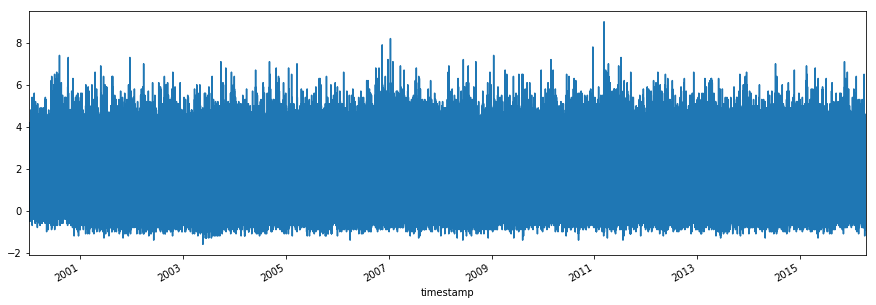

In [8]:
df.mag.plot(figsize=(15,5))

In [9]:
df.horizontal_error.describe()

count    1.767229e+06
mean     8.866591e-01
std      1.091669e+00
min      0.000000e+00
25%      3.177859e-01
50%      4.829156e-01
75%      1.088201e+00
max      4.349794e+01
Name: horizontal_error, dtype: float64

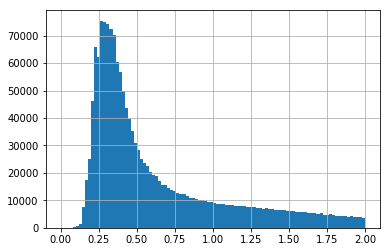

In [10]:
df.horizontal_error.hist(bins=100, range=(0,2))

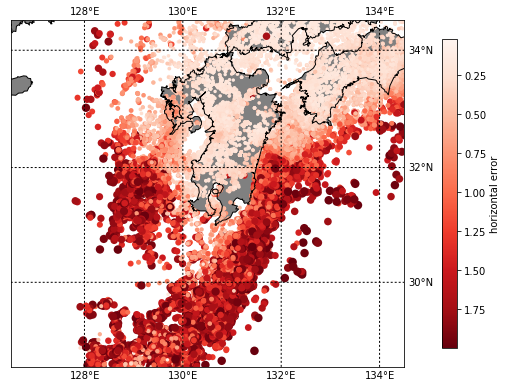

In [11]:
fig, ax = plt.subplots(1, figsize=(8,8))

m = Basemap(projection='merc'
           ,llcrnrlat=28.5
           ,urcrnrlat=34.5
           ,llcrnrlon=126.5
           ,urcrnrlon=134.5
           ,resolution='i'
           ,area_thresh=1000
           ,ax=ax)

labels = np.arange(0,180,2)
m.drawparallels(labels, labels=labels)
m.drawmeridians(labels, labels=labels)

m.drawcoastlines()
m.fillcontinents(color='gray', zorder=0)

# # data = df[(df.mag > 2.5) & df.lat.between(32,34) & df.lon.between(130,132)]
d = df[(df.mag > 1)].copy()
d = d[d.lat.between(28.5, 34.5) & d.lon.between(126.5, 134.5)]
d = d[d.horizontal_error <= 2.0]


x, y = m(d.lon.values, d.lat.values)

cbar = ax.scatter(x, y, c=d.horizontal_error.values, s=10*np.exp(d.horizontal_error.values), edgecolor='None'
                  , cmap='Reds')
c1 = fig.colorbar(cbar, label='horizontal error',fraction=0.0346, pad=0.084)
c1.ax.invert_yaxis()

# sizes = np.exp([3,4,5,6,7])
# label_plot = [ax.scatter([],[], s=s, edgecolors='black', color='white', alpha=0.5) for s in sizes]
# labels = [x for x in range(3,11)]
# ax.legend(label_plot, labels, ncol=10, frameon=True, fontsize=12, handlelength=0.75, loc='upper left'
#         , borderpad = 1.,handletextpad=0.95, title='Magnitude Size', scatterpoints = 1
#         , bbox_to_anchor=(0.18,0.0115))

# equi(m, 130, 30, 50, lw=2)
# equi(m, 132, 32, 50, lw=2)
# equi(m, 130, 34, 50, lw=2, color='red')

In [62]:
m_standard = Basemap(projection='merc', lon_0=0)

def get_cumdist(data):
    hist, edges = np.histogram(a=data, bins=100, range=(0,10))
    chist = np.cumsum(hist[::-1])
    return edges, hist, chist

def plot_data_with_fit_line(ax, raw_data, chist, radius, **kwargs):
    a, b, bstd, n, mc = calc_fmd_stats_with_mc(raw_data.mag)
    label = radius + ', b={b}, mc={mc}, n={n}'.format(b=round(b,4),mc=mc,n=n)
    ax.scatter(chist[0][::-1][:-1], chist[2], label=label, **kwargs)
#     a, b, bstd, n, mc = calc_fmd_stats_with_mc(raw_data.mag)
    x = np.arange(0, 10, 0.1)
    y = 10**(a - b * x)
    ax.plot(x, y, color='black')

def create_grid(axis_1_min_max, axis_2_min_max, axis_3_min_max
                , axis_1_increment, axis_2_increment, axis_3_increment\
               , columns=['longitude', 'latitude', 'depth']):
    axis_1_min, axis_1_max = axis_1_min_max
    axis_2_min, axis_2_max = axis_2_min_max
    axis_3_min, axis_3_max = axis_3_min_max

    axis_1_numpoints = (axis_1_max - axis_1_min)/axis_1_increment + 1
    axis_2_numpoints = (axis_2_max - axis_2_min)/axis_2_increment + 1
    axis_3_numpoints = (axis_3_max - axis_3_min)/axis_3_increment + 1


    axis_1 = np.linspace(axis_1_min, axis_1_max, axis_1_numpoints)
    axis_2 = np.linspace(axis_2_min, axis_2_max, axis_2_numpoints)
    axis_3 = np.linspace(axis_3_min, axis_3_max, axis_3_numpoints)

    axis123 = list(product(axis_1, axis_2, axis_3))
    grid = pd.DataFrame(axis123, columns=columns)
    return grid

def get_node_data(node, radius, data, m=m_standard):
#     m = Basemap(projection='robin', lon_0=0)
    node_lon = node[0]
    node_lat = node[1]
    radius = radius
    distance_from_node = (radius + 10)/111.133
    data = data[data.lon.between(node_lon-distance_from_node, node_lon+distance_from_node)
              & data.lat.between(node_lat-distance_from_node, node_lon+distance_from_node)].copy()
    xy = np.array(m(data.lon.values, data.lat.values)).transpose()
    node_xy = np.array([m(node_lon, node_lat)])
#     dist = scipy.spatial.distance.cdist(xy, node_xy)/1000. #cdist is meters, we want km
    dist = spatial.distance.cdist(xy, node_xy)/1000. #cdist is meters, we want km
    data['distance'] = dist[:,0]
    data = data[data.distance <= radius]
    return data

def mc_maximum_curvature(magnitudes):
    """
    :param catalog : pandas Series
    :param method : string
    """
    minimum = round(magnitudes.min(), 2)
    bins = np.arange(start=minimum, stop=10, step=0.1)
    hist, edges = np.histogram(a=magnitudes, range=(minimum, 10), bins=bins)
    hist_maximum_index = np.argmax(hist)
    return round(edges[hist_maximum_index], 2)

def fmd_values(magnitudes, bin_width=0.1):
    """
    params magnitudes : numpy.array
    params bin_width : float

    returns a,b,bstd, n-values if above the earthquake count threshold
    else returns np.nans
    """
    length = magnitudes.shape[0]
    minimum = magnitudes.min()
    average = magnitudes.mean()
    b_value = (1 / (average - (minimum - (bin_width / 2)))) * np.log10(np.exp(1))

    square_every_value = np.vectorize(lambda x: x ** 2)
    b_stddev = square_every_value((magnitudes - average).sum()) / (length * (length - 1))
    b_stddev = 2.3 * np.sqrt(b_stddev) * b_value ** 2
    a_value = np.log10(length) + b_value * minimum

    return a_value, b_value, b_stddev, length

def calc_fmd_stats_with_mc(magnitudes):
    if len(magnitudes) > 0:
        mc = mc_maximum_curvature(magnitudes) + 0.2
        magnitudes = magnitudes[magnitudes >= mc]
        if len(magnitudes) > 0:
            fmd_stats = fmd_values(magnitudes)
            return fmd_stats + (mc,)
        else: return (np.nan, np.nan, np.nan, np.nan, np.nan)
    else:
        return (np.nan, np.nan, np.nan, np.nan, np.nan)
    
def node_pipeline(node, data, radius):
    node_data = get_node_data(node=node, data=data, radius=radius)
    statistics = calc_fmd_stats_with_mc(node_data.mag)
    return statistics

def grid_statistic_pipeline(grid, data, radius):
    stats = []
    for node in grid:
        stats.append(node_pipeline(node=node, data=data, radius=radius) + (node[0], node[1]))
    return np.array(stats)

def calc_bootstrapped_fmd_values(df, n_calculations):
    fmd_values = []
    for n in range(n_calculations):
        fmd_values.append(calc_fmd_stats_with_mc(df.ix[np.random.choice(df.index, size=(1, len(d)))[0]].mag))
    return fmd_values

In [67]:
d = df[df.lon.between(130,132) & df.lat.between(32,34)].copy()

In [68]:
d = get_node_data(node=(131, 33), radius=75, data=df[df.lon.between(130,132) & df.lat.between(32,34)].copy())

In [75]:
calc_bootstrapped_fmd_values(d[d.mag>=0.5], 10)

[(5.3514103025436377, 0.87984463389780942, 6.0170711939476106e-16, 54390, 0.7),
 (5.3470805790807141, 0.87697616282020763, 3.3192283897417204e-14, 54100, 0.7),
 (5.3506710104301929, 0.88077648256889152, 2.9073165480263404e-14, 54216, 0.7),
 (5.3496768226790685, 0.87939054579690723, 7.629907613012927e-15, 54213, 0.7),
 (5.3485130808221903, 0.87810582875005816, 6.0407961386644275e-15, 54180, 0.7),
 (5.3527148590762446, 0.88371915376715171, 1.6524888626166833e-15, 54214, 0.7),
 (5.3476472763895728, 0.87838235499808348, 1.2197455059422256e-14, 54048, 0.7),
 (5.3509379093729832, 0.88052869341317019, 1.2225851337570551e-14, 54271, 0.7),
 (5.3533527549755737, 0.88555808432202621, 8.5023196991971531e-15, 54133, 0.7),
 (5.3472007855699779, 0.8770102852176147, 1.9751857523590129e-14, 54112, 0.7)]

In [76]:
b_booted = calc_bootstrapped_fmd_values(d[d.mag>=0.5], 10000)

In [77]:
b_booted_df = pd.DataFrame(np.array(b_booted), columns=['a', 'b', 'bstd', 'n', 'mc'])

In [80]:
b_booted_df.describe()

,a,b,bstd,n,mc
count,10000.000000,10000.000000,1.000000e+04,10000.000000,1.000000e+04
mean,5.351245,0.882518,1.123683e-14,54135.722500,7.000000e-01
std,0.002849,0.003779,8.365605e-15,133.970995,1.192439e-13
min,5.341468,0.868937,1.662095e-18,53656.000000,7.000000e-01
25%,5.349324,0.879948,4.561908e-15,54044.000000,7.000000e-01
50%,5.351281,0.882503,9.570625e-15,54136.000000,7.000000e-01
75%,5.353148,0.885020,1.620403e-14,54227.000000,7.000000e-01
max,5.362567,0.896388,5.080354e-14,54660.000000,7.000000e-01


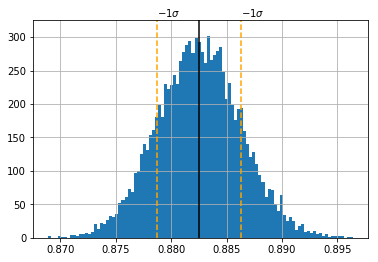

In [93]:
ax = b_booted_df.b.hist(bins=100)
bstd = b_booted_df.b.std()
bavg = b_booted_df.b.mean()
low = bavg - bstd
high = bavg + bstd
ax.plot((low, low), (0, 325), linestyle='--', color='orange')
ax.plot((high, high), (0, 325), linestyle='--', color='orange')
ax.plot((bavg, bavg), (0,325), color='black')
ax.set_ylim(0, 325)
ax.text(x=low, y=330, s='$-1\sigma$')
ax.text(x=high, y=330, s='$-1\sigma$')

In [14]:
lon_i = np.linspace(130, 132, 201).round(4)

In [15]:
lat_i = np.linspace(32, 34, 201).round(4)

In [16]:
from itertools import product
new_index = [x for x in product(lon_i, lat_i)]

In [17]:
bdf = grid_statistic_pipeline(grid=new_index, data=d[d.mag > 0.5].copy(), radius=5)
#start time 13:33 -> 13:14

/home/max/anaconda2/envs/pymap27/lib/python2.7/site-packages/ipykernel/__main__.py:78: RuntimeWarning: invalid value encountered in divide


In [18]:
bdf = pd.DataFrame(bdf, columns=['a','b','bstd','n','mc', 'lon', 'lat'])

In [19]:
# bdf[bdf.n < 50][['a','b','bstd','n','mc']] = np.nan
#df.loc[df['A'] > 2, 'B'] = new_val
bdf.loc[bdf['n'] < 50, ['a','b','bstd','n','mc']] = np.nan

In [20]:
bdf.describe()

,a,b,bstd,n,mc,lon,lat
count,8441.000000,8441.000000,8.441000e+03,8441.000000,8441.000000,40401.000000,40401.000000
mean,2.939275,0.900957,1.286521e-15,229.139912,0.853619,131.000000,33.000000
std,0.333663,0.150114,1.738682e-15,335.815286,0.100444,0.580237,0.580237
min,2.178066,0.453966,0.000000e+00,50.000000,0.800000,130.000000,32.000000
25%,2.705086,0.796140,3.480029e-16,81.000000,0.800000,130.500000,32.500000
50%,2.886311,0.894684,7.458655e-16,128.000000,0.800000,131.000000,33.000000
75%,3.144554,0.990496,1.495514e-15,227.000000,0.900000,131.500000,33.500000
max,4.078856,1.518512,2.085357e-14,3560.000000,1.400000,132.000000,34.000000


In [21]:
zi = bdf.pivot(index='lat', columns='lon', values='b').values

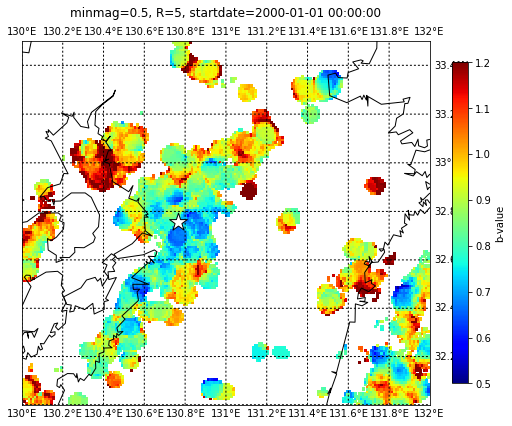

In [22]:
# from matplotlib.colors import LogNorm

fig, ax = plt.subplots(figsize=(8,8))
m = Basemap(projection='merc'
        , llcrnrlat=32        # the LOWER LEFT corner of latitude
        , urcrnrlat=33.5        # the UPPER RIGHT corner of latitude
        , llcrnrlon=130      # the LOWER LEFT corner of longitude
        , urcrnrlon=132
        , resolution='i'
        , ax=ax)

m.drawcoastlines()
lines = np.arange(0,180,0.2)
m.drawparallels(lines, labels=lines)
m.drawmeridians(lines, labels=lines)

xi, _yi = m(lon_i, np.zeros_like(lon_i))
_xi, yi = m(np.zeros_like(lat_i), lat_i)

x, y = m(lon_i, lat_i)

xi, yi = np.meshgrid(xi, yi)

zi = np.ma.masked_invalid(zi)

# cbar = ax.pcolormesh(xi, yi, zi, cmap='jet', norm=LogNorm())
cbar = ax.pcolormesh(xi, yi, zi, cmap='jet', vmin=0.5, vmax=1.2)

fig.colorbar(cbar, label='b-value', fraction=0.036, pad=0.05)
main_shock = (130.763, 32.7545)

x, y = m(main_shock[0], main_shock[1])
ax.scatter(x, y, marker='*', s=350, color='white', edgecolor='black', zorder=20)
ax.set_title('minmag=0.5, R=5, startdate={s}'.format(s=start_date), y=1.05)

In [49]:
lon_i.shape

(201,)

In [50]:
lat_i.shape

(201,)

# 4 locations from before (low/high b, max slip, hypocenter)

In [24]:
# max_slip = (130.9372, 32.84189)
# fm_main = (130.763, 32.7545)#, 128, 74, -14)
# high_b = (131.25, 33.15,)
# low_b = (130.5, 32.5)

In [25]:
# df_min = df[df.mag > 1.5].copy()

In [26]:
# get_node_data(node=low_b, radius=15, data=df_min).describe()

In [27]:
# df['hz_err_deg'] = df['horizontal_error'] / 111.113

In [28]:
# b_hypo = []
# for r in range(100):
#     loc_err_df = df.copy()
#     loc_err_df['lon'] = loc_err_df['lon'] + np.random.uniform(-1,1) * loc_err_df['horizontal_error']
#     loc_err_df['lat'] = loc_err_df['lat'] + np.random.uniform(-1,1) * loc_err_df['horizontal_error']
#     node_df = get_node_data(node=fm_main, radius=15, data=loc_err_df)
#     a, b, bstd, n, mc = calc_fmd_stats_with_mc(node_df.mag)
#     b_hypo.append(b)

In [29]:
# def generate_b_based_on_location_error(df, location, radius):
#     err_df = df.copy()
#     err_df['lon'] = err_df['lon'] + np.random.uniform(-1, 1) * err_df['hz_err_deg']
#     err_df['lat'] = err_df['lat'] + np.random.uniform(-1, 1) * err_df['hz_err_deg']
#     node_df = get_node_data(node=location, radius=radius, data=err_df)
#     a, b, bstd, n, mc = calc_fmd_stats_with_mc(node_df.mag)
#     return a, b, bstd, n, mc

In [30]:
# %timeit generate_b_based_on_location_error(df=df, location=fm_main, radius=15)

# hypocenter b-value distribution

In [31]:
# b10000samples = [generate_b_based_on_location_error(df=df[df.mag>1.5], location=fm_main, radius=15) for x in range(10000)]

In [32]:
# b10000df = pd.DataFrame(np.array(b10000samples), columns=['a','b','bstd','n','mc'])
# ax = b10000df.b.hist(bins=100)
# ax.set_title('hypocenter')

In [33]:
# b10000df.describe()

# low-bvalue

In [34]:
# low_b_10000_samples = [generate_b_based_on_location_error(df=df[df.mag>1.5]
#                                                           , location=low_b, radius=15) for x in range(10000)]

In [35]:
# low_b_10000_samples = pd.DataFrame(np.array(low_b_10000_samples), columns=['a','b','bstd','n','mc'])
# ax = low_b_10000_samples.b.hist(bins=100)
# ax.set_title('low b-value')

# max slip

In [36]:
# max_slip_10000_samples = [generate_b_based_on_location_error(df=df[df.mag>1.5]
#                                                           , location=max_slip, radius=15) for x in range(10000)]

In [37]:
# max_slip_10000_samples = pd.DataFrame(np.array(max_slip_10000_samples), columns=['a','b','bstd','n','mc'])
# ax = max_slip_10000_samples.b.hist(bins=100)
# ax.set_title('max slip')

# high b value

In [38]:
# high_b_10000_samples = [generate_b_based_on_location_error(df=df[df.mag>1.5]
#                                                           , location=high_b, radius=15) for x in range(10000)]

In [39]:
# high_b_10000_samples = pd.DataFrame(np.array(high_b_10000_samples), columns=['a','b','bstd','n','mc'])
# ax = high_b_10000_samples.b.hist(bins=100)
# ax.set_title('low b-value')

In [40]:
# err_df = df.copy()

# %timeit err_df['lon'] = err_df['lon'] + np.random.uniform(-1, 1) * err_df['hz_err_deg']


In [41]:
# err_df['hz_err_deg'].describe()

In [42]:
# pd.DataFrame(b_hypo).hist()

In [43]:
# def generate_b_based_on_location_error(df, samples, location, radius):
#     b_hypo = []
#     for r in range(samples):
#         loc_err_df = df.copy()
#         loc_err_df = get_node_data(node=location, radius=radius, data=loc_err_df)
#         loc_err_df['lon'] = loc_err_df['lon'] + np.random.uniform(-1,1) * loc_err_df['hz_err_deg']
#         loc_err_df['lat'] = loc_err_df['lat'] + np.random.uniform(-1,1) * loc_err_df['hz_err_deg']
# #         node_df = get_node_data(node=location, radius=radius, data=loc_err_df)
#         a, b, bstd, n, mc = calc_fmd_stats_with_mc(loc_err_df.mag)
#         b_hypo.append(b)
#     return np.array(b_hypo)

In [44]:
# b_hypo

In [45]:
# hypo_b = generate_b_based_on_location_error(df=df, samples=10000, location=fm_main, radius=15)

In [46]:
# hypo_b

In [47]:
# (1.6/10*10000)/60